# Importing Required Libraries

In [1]:
import os
import torch
import pickle
from datasets import load_dataset
import random
import numpy as np
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.transforms.functional import pil_to_tensor, to_pil_image

/data/home1/shishirm/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Makeing Results Reproducible

In [2]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Reading the Dataset


In [3]:
data = load_dataset('./tiny-imagenet', split='train')
test = load_dataset('./tiny-imagenet', split='valid')

In [4]:
print(data)
print(test)

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})


In [5]:
def get_tensor_data(data):
    tensor_images_list = [pil_to_tensor(img).to(torch.float32) for img in data["image"]]
    tensor_labels = data["label"]
    remove_indices = []

    for i in range(len(tensor_images_list)):
        if tensor_images_list[i].shape != (3, 64, 64):
            remove_indices.append(i)

    for i in range(len(remove_indices) - 1, -1, -1):
        tensor_images_list.pop(remove_indices[i])
        tensor_labels.pop(remove_indices[i])

    print("No of images =", len(tensor_images_list))
    print("No of labels =", len(tensor_labels))
    print("No of removed images =", len(remove_indices))

    return torch.stack(tensor_images_list, dim=0) / 255, torch.tensor(tensor_labels)

In [6]:
data_images, data_labels = get_tensor_data(data)
test_images, test_labels = get_tensor_data(test)

No of images = 98179
No of labels = 98179
No of removed images = 1821
No of images = 9832
No of labels = 9832
No of removed images = 168


# Showing examples from datasets for sanity checking

In [7]:
def show_example(image, label):
  print("Label :", label.item())
  pyplot.imshow(to_pil_image(image))

index = 30065
Label : 60


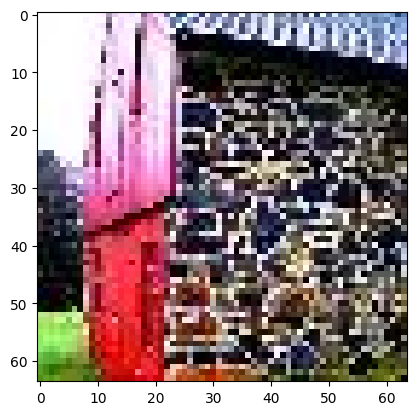

In [8]:
index = random.randint(0, 98179)
print("index =", index)
show_example(data_images[index], data_labels[index])

index = 5536
Label : 112


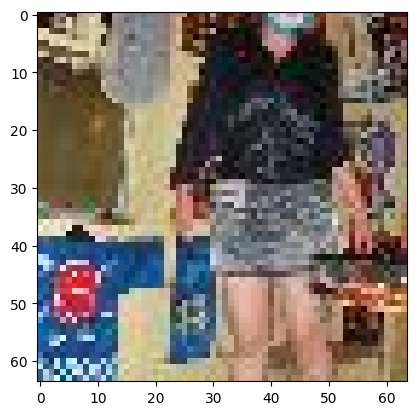

In [9]:
index = random.randint(0, 9832)
print("index =", index)
show_example(test_images[index], test_labels[index])

# Train - Validation set split

In [10]:
train_examples = 90000
validation_examples = 8179

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.X = images
        self.Y = labels

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.Y[index])


dataset = CustomDataset(data_images, data_labels)
train, validation = random_split(dataset, [train_examples, validation_examples])
testset = CustomDataset(test_images, test_labels)

# Defining the Models

In [11]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3)
    self.batch1 = nn.BatchNorm2d(64)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.batch2 = nn.BatchNorm2d(128)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.batch3 = nn.BatchNorm2d(256)

    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
    self.batch4 = nn.BatchNorm2d(512)

    self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
    self.batch5 = nn.BatchNorm2d(1024)

    self.maxpool = nn.MaxPool2d(2, 2)
    self.avgpool = nn.AvgPool2d(4, 4)
    self.relu = nn.PReLU()
    self.drop1 = nn.Dropout(0.2)
    self.drop2 = nn.Dropout2d(0.2)

    self.fc1 = nn.Linear(1024, 2048)
    self.fc2 = nn.Linear(2048, 512)
    self.fc3 = nn.Linear(512, 200)

  def forward(self, x):
    # x.shape = (B x 3 x 64 x 64)

    x1 = self.drop2(self.batch1(self.conv1(x))) # x1.shape = (B x 64 x 64 x 64)
    x = self.maxpool(self.relu(x1))
    # x.shape = (B x 64 x 32 x 32)

    x2 = self.drop2(self.batch2(self.conv2(x))) # x2.shape = (B x 128 x 32 x 32)
    x = self.maxpool(self.relu(x2))
    # x.shape = (B x 128 x 16 x 16)

    # x3 = self.drop(self.batch3(self.conv5(x + self.maxpool(x2)))) # x3.shape = (B x 256 x 16 x 16)
    x3 = self.drop2(self.batch3(self.conv3(x))) # x3.shape = (B x 256 x 16 x 16)
    x = self.maxpool(self.relu(x3))
    # x.shape = (B x 256 x 8 x 8)

    # x4 = self.drop(self.batch4(self.conv8(x + self.maxpool(x3)))) # x4.shape = (B x 512 x 8 x 8)
    x4 = self.drop2(self.batch4(self.conv4(x))) # x4.shape = (B x 512 x 8 x 8)
    x = self.maxpool(self.relu(x4))
    # x.shape = (B x 512 x 4 x 4)

    # x = self.relu(self.drop(self.batch5(self.conv11(x + self.maxpool(x4)))))
    x = self.relu(self.drop2(self.batch5(self.conv5(x))))
    x = self.avgpool(x)
    # x.shape = (B x 512 x 1 x 1)

    x = torch.flatten(x, 1) # flatten all dimensions except batch (0th dim)
    x = self.relu(self.drop1(self.fc1(x)))
    x = self.relu(self.drop1(self.fc2(x)))
    x = self.fc3(x)
    return x

In [14]:
model = CNN().to(device)
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,472
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         Dropout2d-3           [-1, 64, 64, 64]               0
             PReLU-4           [-1, 64, 64, 64]               1
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
       BatchNorm2d-7          [-1, 128, 32, 32]             256
         Dropout2d-8          [-1, 128, 32, 32]               0
             PReLU-9          [-1, 128, 32, 32]               1
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
      BatchNorm2d-12          [-1, 256, 16, 16]             512
        Dropout2d-13          [-1, 256, 16, 16]               0
            PReLU-14          [-1, 256,

# Helper Functions to Train and Test the Model

In [15]:
def validatioon_step(model, validation_loader, loss_function):
    model.eval()
    validation_loss = 0.0
    validation_correct = 0
    with torch.no_grad():
      for j, (x_val, y_val) in enumerate(validation_loader):
        x_val = x_val.to(device)
        y_val = y_val.long().to(device)

        y_pred = model(x_val)
        loss = loss_function(y_pred, y_val)

        _, predicted = torch.max(y_pred.data, dim=1)
        validation_correct += (predicted == y_val).sum().item()

        validation_loss += loss.item()

    return validation_loss, validation_correct


In [16]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.long().to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [17]:
def fit(model, optimizer_fn, scheduler_fn, loss_fn, train_loader, validation_loader, test_loader, learning_rate, num_epochs):
  history = []
  accuracies = []
  optimizer = optimizer_fn(model.parameters(), learning_rate)
  scheduler = scheduler_fn(optimizer, step_size = 10, gamma = 0.5)
  
  for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, (x_batch, y_batch) in enumerate(train_loader):
      x_batch = x_batch.to(device)
      y_batch = y_batch.long().to(device)

      y_pred = model(x_batch)
      loss = loss_fn(y_pred, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      _, predicted = torch.max(y_pred.data, dim=1)
      train_correct += (predicted == y_batch).sum().item()
      train_loss += loss.item()

    validation_loss, validation_correct = validatioon_step(model, validation_loader, loss_fn)
    scheduler.step()

    if ((epoch + 1) % 5) == 0:
      accuracy = evaluate(model, test_loader)
      print("Test accuracy after", epoch+1, "epochs is =", accuracy)
      accuracies.append(accuracy)

    print("Epoch", epoch+1, "-\tTraining Loss :", train_loss, "\tValidation Loss :", validation_loss)
    history.append({"train_loss" : train_loss/train_examples,
                    "validation_loss" : validation_loss/validation_examples,
                    "train_accuracy" : 100*train_correct/train_examples,
                    "validation_accuracy" : 100*validation_correct/validation_examples})

  return history, accuracies

In [18]:
def plot_losses(history):
  train_losses = []
  validation_losses = []

  for result in history:
    train_losses.append(result["train_loss"])
    validation_losses.append(result["validation_loss"])

  pyplot.plot(train_losses, '-bx')
  pyplot.plot(validation_losses, '-rx')
  pyplot.xlabel('epoch')
  pyplot.ylabel('loss')
  pyplot.legend(['Training', 'Validation'])
  pyplot.title('Loss vs. No. of epochs')

In [19]:
def plot_accuracies(history):
  train_accuracies = []
  validation_accuracies = []

  for result in history:
    train_accuracies.append(result["train_accuracy"])
    validation_accuracies.append(result["validation_accuracy"])

  pyplot.plot(train_accuracies, '-bx')
  pyplot.plot(validation_accuracies, '-rx')
  pyplot.xlabel('epoch')
  pyplot.ylabel('acurracy')
  pyplot.legend(['Training', 'Validation'])
  pyplot.title('Acurracy vs. No. of epochs')

# Training the models

In [20]:
model = CNN().to(device)

train_loader = DataLoader(train, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation, batch_size=256, shuffle=True)
test_loader = DataLoader(testset, batch_size=256, shuffle=False)
optimizer = torch.optim.AdamW
loss_function = F.cross_entropy
scheduler = torch.optim.lr_scheduler.StepLR

history, accuracies = fit(model, optimizer, scheduler, loss_function, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=50)

  2%|▏         | 1/50 [00:33<27:29, 33.67s/it]

Epoch 1 -	Training Loss : 4092.5341625213623 	Validation Loss : 162.7658052444458


  4%|▍         | 2/50 [01:04<25:24, 31.77s/it]

Epoch 2 -	Training Loss : 3554.3067212104797 	Validation Loss : 156.85483312606812


  6%|▌         | 3/50 [01:34<24:17, 31.02s/it]

Epoch 3 -	Training Loss : 3422.436468601227 	Validation Loss : 150.29075050354004


  8%|▊         | 4/50 [02:04<23:26, 30.57s/it]

Epoch 4 -	Training Loss : 3297.2376732826233 	Validation Loss : 143.60000371932983


 10%|█         | 5/50 [02:35<23:02, 30.73s/it]

Test accuracy after 5 epochs is = 8.767290480065094
Epoch 5 -	Training Loss : 3201.750783443451 	Validation Loss : 136.3630657196045


 12%|█▏        | 6/50 [03:05<22:22, 30.51s/it]

Epoch 6 -	Training Loss : 3104.179916858673 	Validation Loss : 134.36507320404053


 14%|█▍        | 7/50 [03:35<21:44, 30.33s/it]

Epoch 7 -	Training Loss : 3028.319987297058 	Validation Loss : 130.60703420639038


 16%|█▌        | 8/50 [04:05<21:10, 30.26s/it]

Epoch 8 -	Training Loss : 2967.5944521427155 	Validation Loss : 126.98547101020813


 18%|█▊        | 9/50 [04:35<20:33, 30.09s/it]

Epoch 9 -	Training Loss : 2913.1339831352234 	Validation Loss : 125.09720206260681


 20%|██        | 10/50 [05:05<20:13, 30.35s/it]

Test accuracy after 10 epochs is = 15.419039869812856
Epoch 10 -	Training Loss : 2869.987412929535 	Validation Loss : 124.73140001296997


 22%|██▏       | 11/50 [05:36<19:40, 30.28s/it]

Epoch 11 -	Training Loss : 2695.7515256404877 	Validation Loss : 115.25003266334534


 24%|██▍       | 12/50 [06:05<19:05, 30.15s/it]

Epoch 12 -	Training Loss : 2630.079466819763 	Validation Loss : 112.09740996360779


 26%|██▌       | 13/50 [06:38<19:01, 30.86s/it]

Epoch 13 -	Training Loss : 2590.316091775894 	Validation Loss : 113.72373151779175


 28%|██▊       | 14/50 [07:08<18:25, 30.70s/it]

Epoch 14 -	Training Loss : 2542.898025035858 	Validation Loss : 115.3855528831482


 30%|███       | 15/50 [07:39<17:50, 30.59s/it]

Test accuracy after 15 epochs is = 22.90480065093572
Epoch 15 -	Training Loss : 2500.8140699863434 	Validation Loss : 109.39257502555847


 32%|███▏      | 16/50 [08:08<17:07, 30.23s/it]

Epoch 16 -	Training Loss : 2461.0941321849823 	Validation Loss : 107.49389815330505


 34%|███▍      | 17/50 [08:38<16:32, 30.07s/it]

Epoch 17 -	Training Loss : 2426.0023782253265 	Validation Loss : 107.23438715934753


 36%|███▌      | 18/50 [09:07<15:57, 29.92s/it]

Epoch 18 -	Training Loss : 2387.1848618984222 	Validation Loss : 106.82964086532593


 38%|███▊      | 19/50 [09:37<15:25, 29.85s/it]

Epoch 19 -	Training Loss : 2351.701499938965 	Validation Loss : 105.41361331939697


 40%|████      | 20/50 [10:09<15:11, 30.39s/it]

Test accuracy after 20 epochs is = 28.12245728234337
Epoch 20 -	Training Loss : 2325.52748298645 	Validation Loss : 101.10873770713806


 42%|████▏     | 21/50 [10:40<14:49, 30.69s/it]

Epoch 21 -	Training Loss : 2180.248112678528 	Validation Loss : 100.15835165977478


 44%|████▍     | 22/50 [11:13<14:39, 31.40s/it]

Epoch 22 -	Training Loss : 2116.930870294571 	Validation Loss : 94.69652271270752


 46%|████▌     | 23/50 [11:47<14:26, 32.08s/it]

Epoch 23 -	Training Loss : 2084.4284081459045 	Validation Loss : 94.54283022880554


 48%|████▊     | 24/50 [12:19<13:57, 32.21s/it]

Epoch 24 -	Training Loss : 2050.812040567398 	Validation Loss : 94.33623313903809


 50%|█████     | 25/50 [12:47<12:50, 30.83s/it]

Test accuracy after 25 epochs is = 33.523189585028476
Epoch 25 -	Training Loss : 2017.8898403644562 	Validation Loss : 92.33106899261475


 52%|█████▏    | 26/50 [13:12<11:35, 29.00s/it]

Epoch 26 -	Training Loss : 1994.0738389492035 	Validation Loss : 93.46018600463867


 54%|█████▍    | 27/50 [13:37<10:39, 27.80s/it]

Epoch 27 -	Training Loss : 1962.242116689682 	Validation Loss : 90.73034691810608


 56%|█████▌    | 28/50 [14:02<09:59, 27.24s/it]

Epoch 28 -	Training Loss : 1934.0240459442139 	Validation Loss : 89.86704397201538


 58%|█████▊    | 29/50 [14:28<09:18, 26.62s/it]

Epoch 29 -	Training Loss : 1907.9349954128265 	Validation Loss : 92.02524161338806


 60%|██████    | 30/50 [14:55<08:54, 26.71s/it]

Test accuracy after 30 epochs is = 35.058991049633846
Epoch 30 -	Training Loss : 1880.3994839191437 	Validation Loss : 89.76903223991394


 62%|██████▏   | 31/50 [15:22<08:32, 26.96s/it]

Epoch 31 -	Training Loss : 1775.8782186508179 	Validation Loss : 87.269371509552


 64%|██████▍   | 32/50 [15:54<08:29, 28.31s/it]

Epoch 32 -	Training Loss : 1739.9342341423035 	Validation Loss : 86.95881962776184


 66%|██████▌   | 33/50 [16:25<08:19, 29.38s/it]

Epoch 33 -	Training Loss : 1713.9443893432617 	Validation Loss : 88.96051454544067


 68%|██████▊   | 34/50 [16:58<08:03, 30.20s/it]

Epoch 34 -	Training Loss : 1694.9119997024536 	Validation Loss : 86.36504030227661


 70%|███████   | 35/50 [17:31<07:45, 31.05s/it]

Test accuracy after 35 epochs is = 37.70341741253051
Epoch 35 -	Training Loss : 1671.8113193511963 	Validation Loss : 88.00007724761963


 72%|███████▏  | 36/50 [18:05<07:27, 31.98s/it]

Epoch 36 -	Training Loss : 1647.5790050029755 	Validation Loss : 84.8517816066742


 74%|███████▍  | 37/50 [18:35<06:50, 31.61s/it]

Epoch 37 -	Training Loss : 1629.4027560949326 	Validation Loss : 86.33444476127625


 76%|███████▌  | 38/50 [19:06<06:17, 31.42s/it]

Epoch 38 -	Training Loss : 1609.3318430185318 	Validation Loss : 85.84732174873352


 78%|███████▊  | 39/50 [19:37<05:43, 31.22s/it]

Epoch 39 -	Training Loss : 1592.1139348745346 	Validation Loss : 85.43266034126282


 80%|████████  | 40/50 [20:09<05:13, 31.36s/it]

Test accuracy after 40 epochs is = 37.77461350691619
Epoch 40 -	Training Loss : 1574.829153418541 	Validation Loss : 88.01446652412415


 82%|████████▏ | 41/50 [20:41<04:43, 31.49s/it]

Epoch 41 -	Training Loss : 1512.7989262342453 	Validation Loss : 85.11948275566101


 84%|████████▍ | 42/50 [21:13<04:12, 31.60s/it]

Epoch 42 -	Training Loss : 1490.7020403146744 	Validation Loss : 84.04264569282532


 86%|████████▌ | 43/50 [21:44<03:39, 31.43s/it]

Epoch 43 -	Training Loss : 1473.325105190277 	Validation Loss : 84.73154067993164


 88%|████████▊ | 44/50 [22:15<03:08, 31.47s/it]

Epoch 44 -	Training Loss : 1454.3039181232452 	Validation Loss : 83.70313286781311


 90%|█████████ | 45/50 [22:48<02:38, 31.74s/it]

Test accuracy after 45 epochs is = 39.473148901545976
Epoch 45 -	Training Loss : 1447.8230895996094 	Validation Loss : 84.48479795455933


 92%|█████████▏| 46/50 [23:18<02:05, 31.25s/it]

Epoch 46 -	Training Loss : 1434.3562849760056 	Validation Loss : 83.69651556015015


 94%|█████████▍| 47/50 [23:48<01:32, 30.96s/it]

Epoch 47 -	Training Loss : 1421.5852969884872 	Validation Loss : 84.82365226745605


 96%|█████████▌| 48/50 [24:18<01:01, 30.78s/it]

Epoch 48 -	Training Loss : 1407.993507862091 	Validation Loss : 83.69307279586792


 98%|█████████▊| 49/50 [24:48<00:30, 30.58s/it]

Epoch 49 -	Training Loss : 1393.4326040744781 	Validation Loss : 84.9764404296875


100%|██████████| 50/50 [25:19<00:00, 30.40s/it]

Test accuracy after 50 epochs is = 40.327502034174124
Epoch 50 -	Training Loss : 1387.0046417713165 	Validation Loss : 83.23728466033936


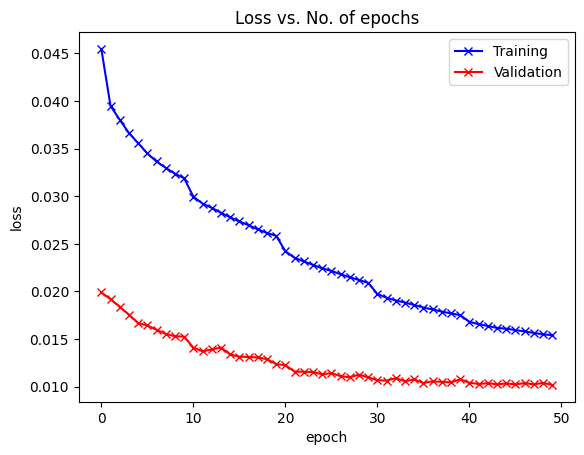

In [21]:
plot_losses(history)

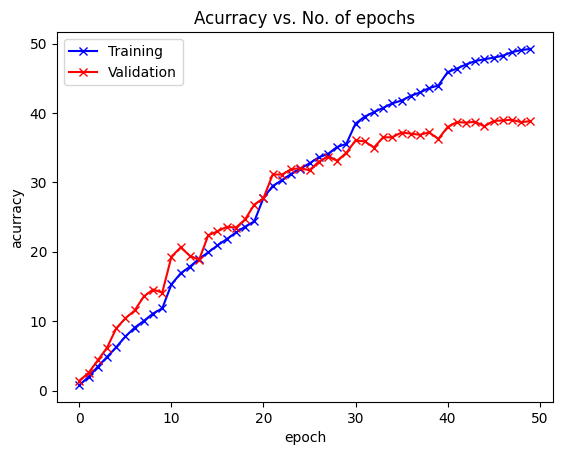

In [22]:
plot_accuracies(history)

In [23]:
print(accuracies)


[8.767290480065094, 15.419039869812856, 22.90480065093572, 28.12245728234337, 33.523189585028476, 35.058991049633846, 37.70341741253051, 37.77461350691619, 39.473148901545976, 40.327502034174124]


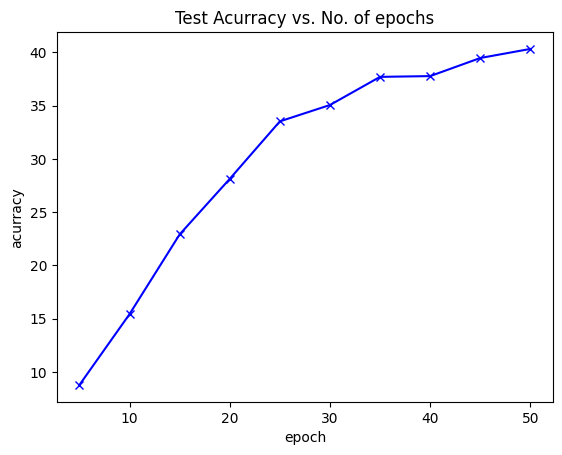

In [24]:
epochs = [i for i in range(5, 51, 5)]
pyplot.plot(epochs, accuracies, '-bx')
pyplot.xlabel('epoch')
pyplot.ylabel('acurracy')
pyplot.title('Test Acurracy vs. No. of epochs')
pyplot.show()